# Load libraries

In [1]:
import os
import pandas as pd
import time
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib.patches import Patch

from functools import partial
import concurrent.futures

# Constants

In [2]:
dataset = ('CAMELS_spat_NH', 'camels_spat')
# countries = ["USA"]
countries = ["CAN"]

# 'countries' to string and lowercase
countries_str = '-'.join(countries).lower()

NUM_BASINS = 2000
StartDate = "1975-10-01"
EndDate = "2019-09-30"

MULTIPROCESSING = 1

# Functions

In [3]:
def process_basin(basin, data_dir):
    df = pd.read_csv(os.path.join(data_dir, basin), index_col=0, parse_dates=True)   
    if df.index[0] <= pd.to_datetime(StartDate) and df.index[-1] >= pd.to_datetime(EndDate):
        
        # Create a Series of dates between the start and end date: 1 if date is present, 0 if missing
        date_range = pd.date_range(start=StartDate, end=EndDate, freq='D')
        # Filter df.index to ensure it's within the specified range
        filtered_index = df.index[(df.index >= StartDate) & (df.index <= EndDate)]
        # Create present_dates series with index filtered to within the range
        present_dates = pd.Series(1, index=filtered_index)
        # Create missing_dates series with index filtered to within the range
        missing_dates = pd.Series(0, index=date_range[~date_range.isin(filtered_index)])
        # Concatenate present_dates and missing_dates and sort by index
        date_presence = pd.concat([present_dates, missing_dates]).sort_index()
        
        # display(date_presence)
        
        # Check for missing days
        if df.index.freq != 'D':
            # Upsample to daily frequency
            df_daily = df.resample('D').mean()
            
            # Check for NaN values
            missing_days = df_daily.isnull().sum()
            if missing_days.any() > 0:  # Use any() method
                print(f"Missing {missing_days.sum()} days found in {basin}")
                return basin, False, date_presence
        return basin, True, date_presence
    else:
        return basin, False, None
    
    
def plot_missing_data_heatmap(df, start_year, end_year, countries_str):
    
    fig, ax = plt.subplots(figsize=(30, 16))
    # Create a heatmap of the missing data with seaborn
    cmap = sns.mpl_palette("Set2", 2)
    sns.heatmap(df, cmap=cmap, cbar=False, ax=ax)
    
    legend_handles = [Patch(color=cmap[True], label='Non Missing Value'),  # red
                    Patch(color=cmap[False], label='Missing Value')]  # green
    plt.legend(handles=legend_handles, ncol=2, bbox_to_anchor=[0.5, 1.02], loc='lower center', fontsize=12, handlelength=1.2)
    plt.tight_layout()
    plt.show()

    # Save the figure
    fig.savefig(f"missing_data_{countries_str}_{dataset[1]}_{start_year}-{end_year}.png", dpi=300)

    
    

# Run

In [ ]:
# Initialize lists to store basin information
selected_basins = []
df_basins_missing = pd.DataFrame()
counter = 0
not_to_stop = True
for country in countries:
    if not_to_stop:
        data_dir = f"../../../../../gladwell/hydrology/SUMMA/summa-ml-models/{dataset[0]}/CAMELS_spat_{country}"
        basins = sorted(os.listdir(data_dir))
        
        if MULTIPROCESSING:
            with concurrent.futures.ProcessPoolExecutor() as executor:
                # Define a partial function to pass the data_dir
                process_basin_partial = partial(process_basin, data_dir=data_dir)
                
                # Process each basin concurrently
                results = [executor.submit(process_basin_partial, basin) for basin in basins]
                
                # Wait for all results to be available
                for result in concurrent.futures.as_completed(results):
                    
                    basin, basin_ok, date_presence = result.result()
                    
                    # Append date_presence to the dataframe
                    if date_presence is not None:
                        df_basins_missing[basin] = date_presence
                    
                    if basin_ok:
                        print(counter, basin_ok)
                        selected_basins.append(basin_ok)
                        
                        counter += 1
                        if counter == NUM_BASINS:
                            break
                        
            print(country, len([res for res in results if res.result() is not None]), '->', len(selected_basins))
            
        else:
            # Initialize lists to store basin information
            for basin in basins[:100]:
                # print(counter, basin)
                _, basin_ok, date_presence = process_basin(basin, data_dir)
                # print(basin_ok, date_presence)
                
                # Append date_presence to the dataframe
                if date_presence is not None:
                    df_basins_missing[basin] = date_presence
                
                if basin_ok:
                    print(counter, basin)
                    selected_basins.append(basin_ok)
                    
                    counter += 1
                    if counter == NUM_BASINS:
                        break

 

In [5]:
# print(df_basins_missing.head())
# print(df_basins_missing.tail())

df_basins_missing.shape

(16071, 503)

In [6]:
# Extract start and end years
start_year = pd.to_datetime(StartDate).year
end_year = pd.to_datetime(EndDate).year

# # Write all selected basin names to a file named after the counter
# with open(f"{len(selected_basins)}_basin_{dataset[1]}_{start_year}-{end_year}.txt", "w") as f:
#     for basin_name in sorted(selected_basins):
#         f.write(basin_name.split('.')[0] + "\n")
    
#     # Remove last newline character
#     f.seek(f.tell() - 1)
#     f.truncate()

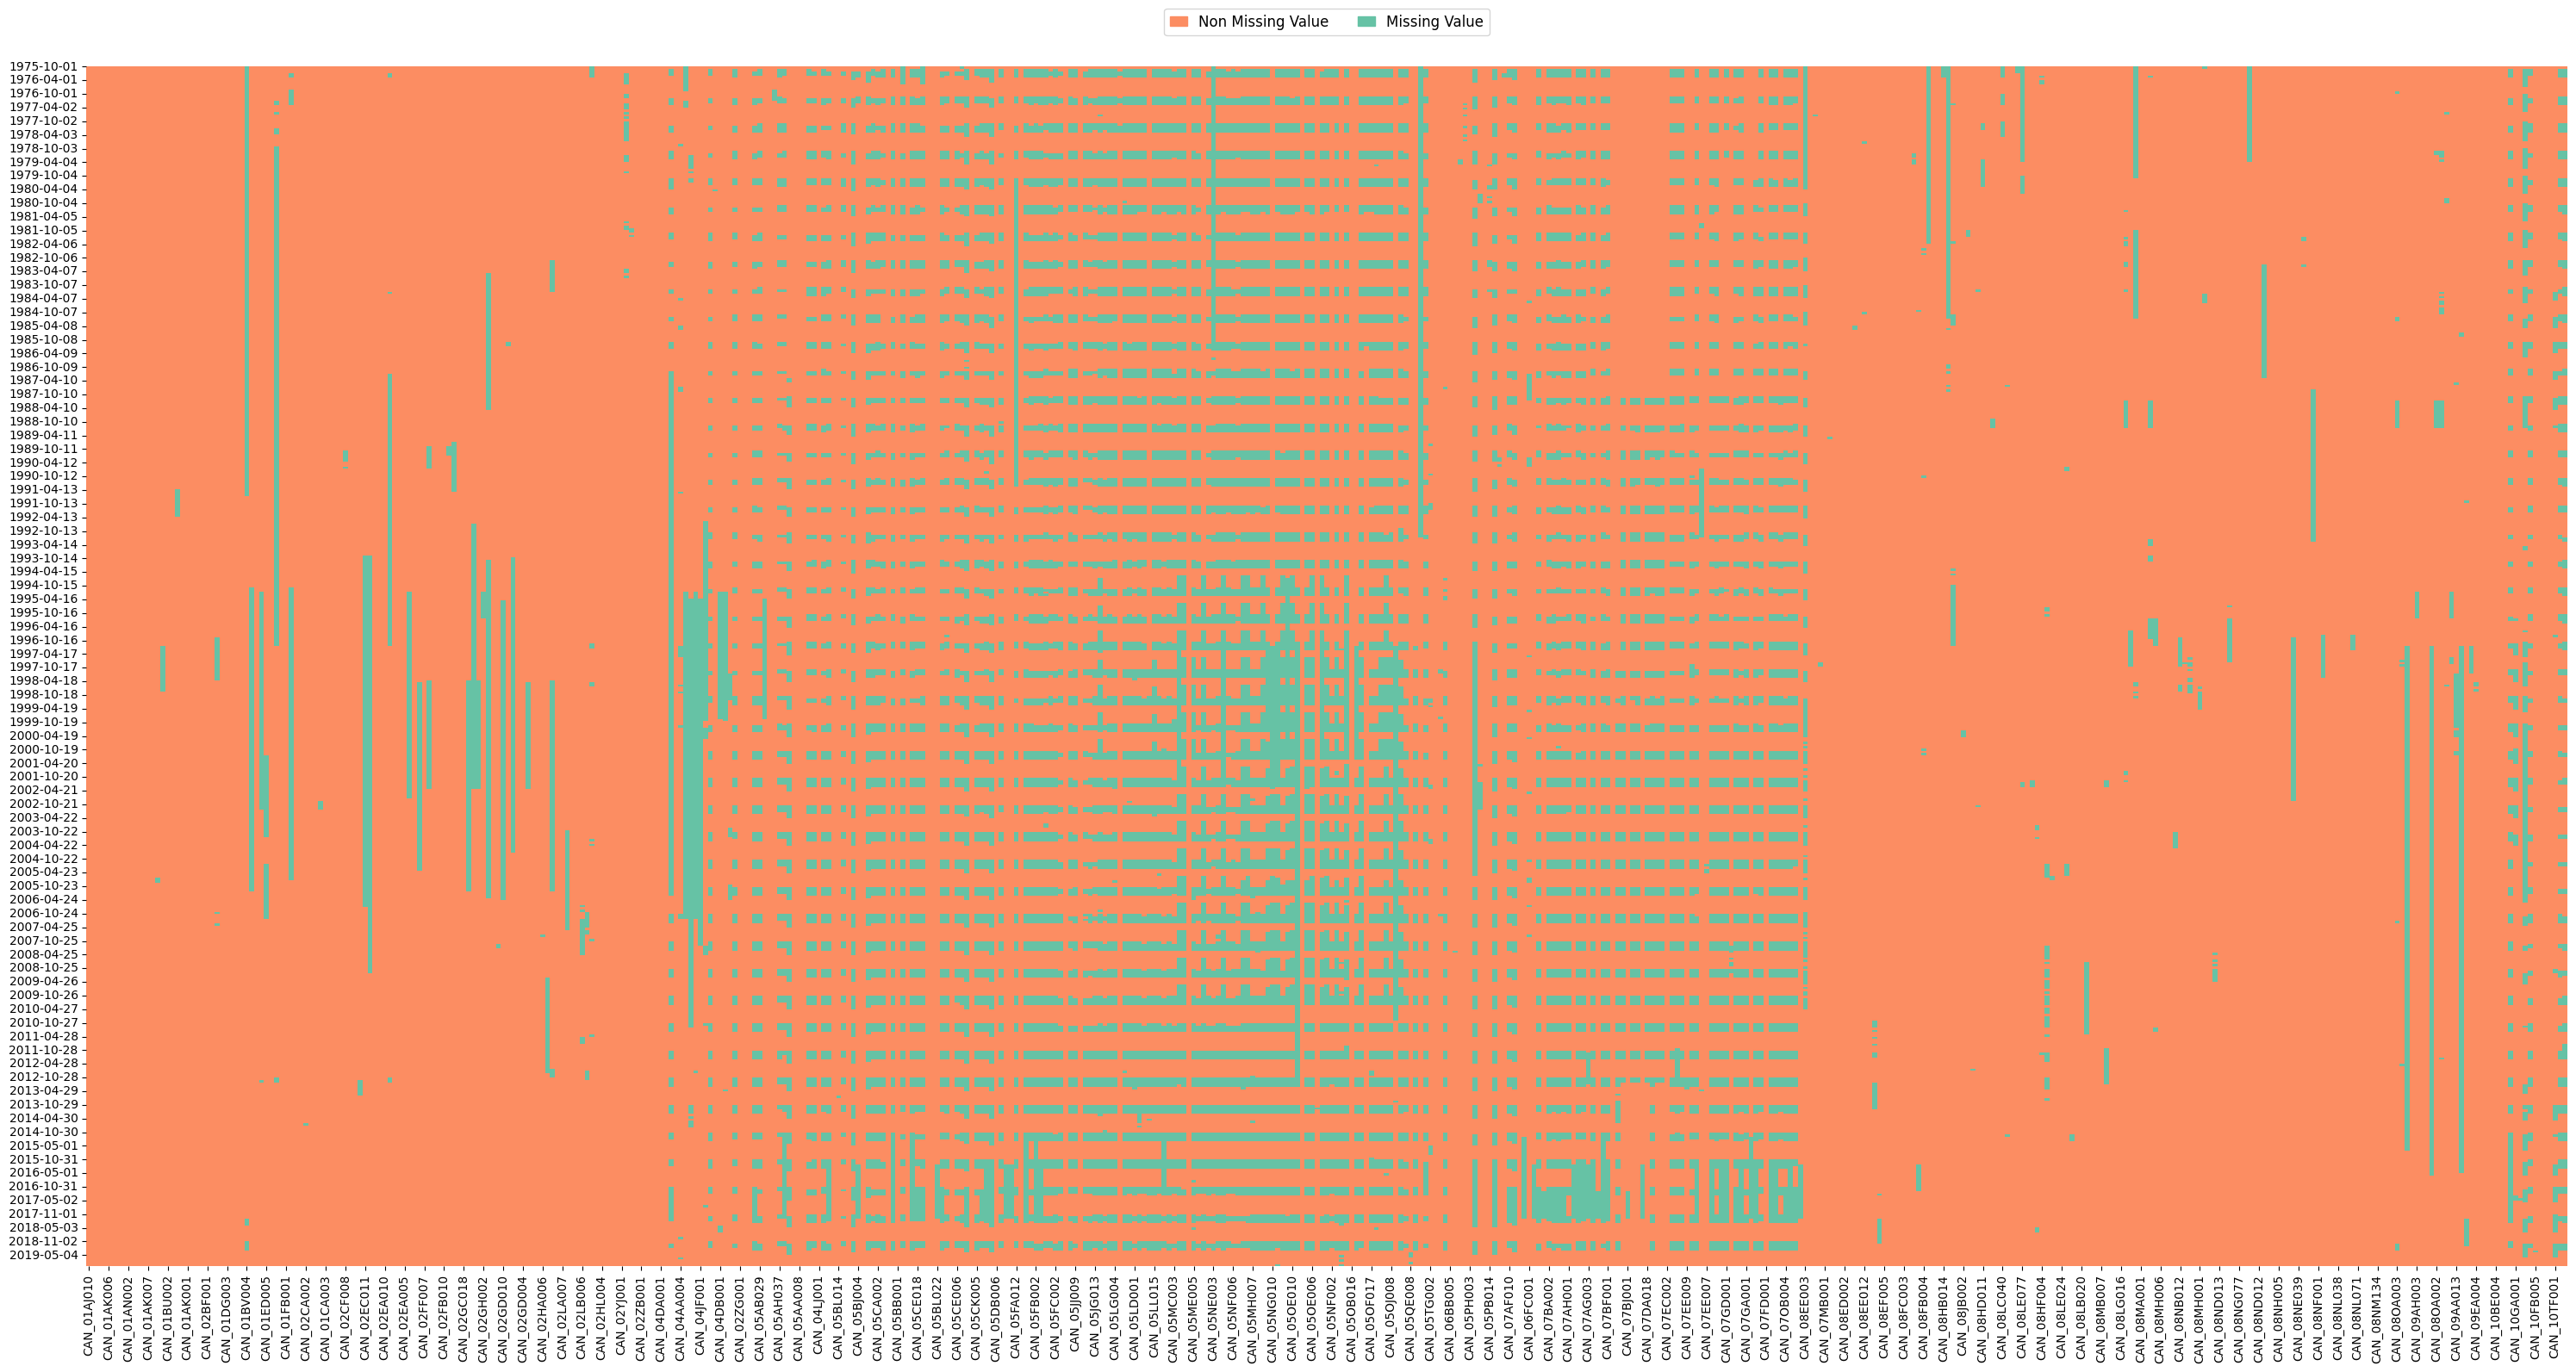

In [8]:
# Rename columns to remove file extension
df_basins_missing.columns = [col.split('.')[0] for col in df_basins_missing.columns]

# Date column to string format and YYYY-MM-DD if needed
if df_basins_missing.index.dtype == 'datetime64[ns]':
    df_basins_missing.index = df_basins_missing.index.strftime('%Y-%m-%d')

plot_missing_data_heatmap(df_basins_missing, start_year=start_year, end_year=end_year, countries_str=countries_str)

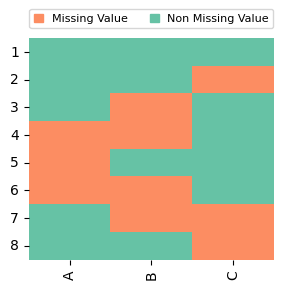

In [9]:
import pandas as pd
df = pd.DataFrame({'A': {1: False, 2: False, 3: False, 4: True, 5: True, 6: True, 7: False, 8: False},
                   'B': {1: False, 2: False, 3: True, 4: True, 5: False, 6: True, 7: True, 8: False},
                   'C': {1: False, 2: True, 3: False, 4: False, 5: False, 6: False, 7: True, 8: True}})
fig, ax = plt.subplots(figsize=(3, 3))
cmap = sns.mpl_palette("Set2", 2)
sns.heatmap(data=df, cmap=cmap, cbar=False)
plt.xticks(rotation=90, fontsize=10)
plt.yticks(rotation=0, fontsize=10)
legend_handles = [Patch(color=cmap[True], label='Missing Value'),  # red
                  Patch(color=cmap[False], label='Non Missing Value')]  # green
plt.legend(handles=legend_handles, ncol=2, bbox_to_anchor=[0.5, 1.02], loc='lower center', fontsize=8, handlelength=.8)
plt.tight_layout()
plt.show()